<a href="https://colab.research.google.com/github/dotdigital26/Tensorflow-Implementation-on-Mnist-Data/blob/main/TensorFlow_FeedForward_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST DIGIT CLASSIFICATION

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

11493376/11490434 [==============================] - 0s 0us/step


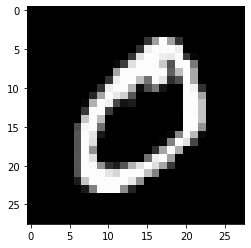

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist
plt.imshow(x_train[1],cmap='gray')

In [ ]:
def sigmoid(x):

  x =np.clip(x, -500, 500) # This helps to limit the value of variable such that every value below min (-500) is renamed as -500 and same applies to max 50
  
  return np.where(x >=0, 1/(1+np.exp(x)))

def dsigmoid(x):
  return sigmoid(x) * (1-sigmoid(x))

def softmax(x):
  b = x.max()
  y = np.exp(x - b)
  return y/y.sum()

def cross_entropy_loss(y, yHat):
  return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, max):
  result = np.zero(10)
  result[x] =1
  return result
  


In [ ]:
#The next is initialization of weights, biases and model architechure. Bad weight initialization can affect our training
#by causing no or slow convergence to the global minimum. In other to avoid that, we need to make sure our weight is initialized 
#to be closer to zero and closer to one. The whole point of this initialization(Xavier/Glorot Initialiation) is to avoid the problem of vanishing gradient which happens,
#when the input of an activation function z=w^Tx + b is far away from the and the gradient of its update function equal 0. To avoid this, use Fan-in and Fanout or completely use 
#we can introduce RELU activation Unit

import math
from numpy.random import default_rng
rng = default_rng(80085)

##Neural Network Layer Sizes: 784 --> 32 --> 32 --> 10
weights =[rng.normal(0,1/math.sqrt(784),(32,784)),
          (rng.normal(0, 1/math.sqrt(32), (32, 32)),
           rng.normal(0, 1/math.sqrt(32), (10,32)))]
biases = [np.zeros(32), np.zeros(32), np.zeros(10)]

#Plotting histogram of layer weights to chevk probability distribution
print('Weight distribution per layer')
for index, layer in enumerate(weights):
  plt.figure()
  plt.suptitle(
      'Layer ' + str(index + 1) + ' with ' + str(layer.shape[0]) +
      'Neurons, ' + str(layer.shape[1]) + ' inputs each  (' + str(layer.size) +
      'weights in total)'
       )
  plt.hist(layer.flatten(), bins=100)

In [ ]:

def feed_forward_sample(sample, y):
  """ Feeds a sample forward through the neural network.
    Parameters:
      sample: 1D numpy array. The input sample (an MNIST digit).
      label: An integer from 0 to 9.

    Returns: The cross entropy loss.
  """
  a = sample.flatten()

  for index, w in enumerate(weights):
    z = np.matmul(w, a) + biases[index]
    if index < len(weights) - 1:
      a = sigmoid(z)
    else:
      a = softmax(z)

  # Calculate loss
  one_hot_y = integer_to_one_hot(y, 10)
  loss = cross_entropy_loss(one_hot_y, a)

  # Convert activations to one hot encoded guess
  one_hot_guess = np.zeros_like(a)
  one_hot_guess[np.argmax(a)] = 1
  
  return loss, one_hot_guess



#Feedforward all training samples
def feed_forward_dataset(x,y):
  losses = np.empty(x.shape[0])
  one_hot_guesses = np.empty((x.shape[0], 10))

  for i in range(x.shape[0]):
    if i == 0 or ((i + 1) % 10000 == 0):
      print(i + 1, "/", x.shape[0], "(", format(((i + 1)/x.shape[0]) * 100, ".2f"), "%)")
    losses[i], one_hot_guesses[i] = feed_forward_sample(x[i], y[i])

  print("\nAverage loss:", np.round(np.average(losses), decimals=2))

  y_one_hot = np.zeros((y.size, 10))
  y_one_hot[np.arange(y.size), y] = 1

  correct_guesses = np.sum(y_one_hot * one_hot_guesses)
  correct_guesses_percent = format((correct_guesses / y.shape[0]) * 100, ".2f")
  print('Accuracy (# of correct guesses):', correct_guesses, "/", y.shape[0], "(",correct_guesses_percent, "%)")

def fee_forward_training_data():
  print("Feeding forward all training data...")
  feed_forward_dataset(x_train, y_train)
  print("")

def fee_forward_test_data():
  print("Feeding forward all test data...")
  feed_forward_dataset(x_test, y_test)
  print("")
fee_forward_test_data()

In [ ]:

def train_one_sample(sample, y, learning_rate=0.003):
  a = sample.flatten()

  # We will store each layer's activations to calculate gradient
  activations = []

  # Feedforward
  for i, w in enumerate(weights): # Each w is a layer's 2D weight matrix
    z = np.matmul(w, a) + biases[i]
    if (i < len(weights) - 1):
      a = sigmoid(z)
    else:  
      a = softmax(z) # softmax on last layer
    activations.append(a)

  # Calculate loss
  one_hot_y = integer_to_one_hot(y, 10)
  loss = cross_entropy_loss(one_hot_y, a)

  # Convert last layer's activations to one hot encoded guess
  one_hot_guess = np.zeros_like(a)
  one_hot_guess[np.argmax(a)] = 1

  # Check whether guess was correct
  correct_guess = (np.sum(one_hot_y * one_hot_guess) == 1)

  weight_gradients = [None] * len(weights)
  bias_gradients = [None] * len(weights)
  activation_gradients = [None] * (len(weights) - 1)
  
  # Backpropagation
  for i in range(len(weights) - 1, -1, -1): # Traverse layers in reverse
    last_layer = i == len(weights) - 1
    second_to_last_layer = i == len(weights) - 2

    if last_layer:
      # Gather all needed variables, making vectors vertical
      y = one_hot_y[:, np.newaxis]
      a = activations[i][:, np.newaxis]
      a_prev = activations[i-1][:, np.newaxis]

      weight_gradients[i] = np.matmul((a - y), a_prev.T)
      bias_gradients[i] = a - y

    else:
      # Gather all needed variables, making vectors vertical
      w_next = weights[i+1]
      a_next = activations[i + 1][:, np.newaxis]
      y = one_hot_y[:, np.newaxis]
      a = activations[i][:, np.newaxis]
      if i > 0:
        a_prev = activations[i-1][:, np.newaxis]
      else:
        # Previous activation is the sample itself
        a_prev = sample.flatten()[:, np.newaxis]

      # Activation gradient
      if second_to_last_layer:
        dCda = np.matmul(w_next.T, (a_next - y))
        activation_gradients[i] = dCda
      else:
        dCda_next = activation_gradients[i+1]
        dCda = np.matmul(w_next.T, (dsigmoid(a_next) * dCda_next))
        activation_gradients[i] = dCda

      # Weights & biases gradients
      x = dsigmoid(a) * dCda
      weight_gradients[i] = np.matmul(x, a_prev.T)
      bias_gradients[i] = x

    # Update weights & biases based on gradient
    weights[i] -= weight_gradients[i] * learning_rate
    biases[i] -= bias_gradients[i].flatten() * learning_rate

def train_one_epoch(learning_rate=0.003):
  print("Training for one epoch over the training dataset...")
  for i in range(x_train.shape[0]):
    if i == 0 or ((i + 1) % 10000 == 0):
      completion_percent = format(((i + 1) / x_train.shape[0]) * 100, ".2f")
      print(i + 1, "/", x_train.shape[0], "(", completion_percent, "%)")
    train_one_sample(x_train[i], y_train[i], learning_rate)
  print("Finished training.\n")

# Train and check accuracy before & after each epoch

feed_forward_test_data()

def test_and_train():
  train_one_epoch()
  feed_forward_test_data()

for i in range(3): # Adjust number of epochs here
  test_and_train()